In [1]:
import numpy as np
import math
import torch as th

%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 工具

## 1 前向过程

###  1.1 schedule $\beta$ 
$$
scale=\frac{1000}{n\_step}
$$

$$
\beta_{start}=0.0001 \times scale\\
\beta_{end}=0.02 \times scale
$$

如果 schedule 使用 "linear" 且 $n\_step=20$ ，则 $scale=50$，$\beta$ 的范围为(0.005,1.0),在该范围内均值采样，则可以得到 $\beta$ 的值，计算方法如下：

In [2]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

In [5]:
get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=20)

array([0.005     , 0.05736842, 0.10973684, 0.16210526, 0.21447368,
       0.26684211, 0.31921053, 0.37157895, 0.42394737, 0.47631579,
       0.52868421, 0.58105263, 0.63342105, 0.68578947, 0.73815789,
       0.79052632, 0.84289474, 0.89526316, 0.94763158, 1.        ])

### 1.2 参数计算

In [3]:
def draw_param(n_steps,param,name):
    plt.plot(list(range(n_steps)),param)
    plt.xlabel('step')
    plt.ylabel(name)
    plt.show()

In [4]:
# Use float64 for accuracy.
n_steps=100
betas=get_named_beta_schedule('linear', num_diffusion_timesteps=n_steps)
betas = np.array(betas, dtype=np.float64)

num_timesteps = int(betas.shape[0])

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)


# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
log_one_minus_alphas_cumprod = np.log(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)


# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))


# log calculation clipped because the posterior variance is 0 at the
# beginning of the diffusion chain.
posterior_log_variance_clipped = np.log(np.append(posterior_variance[1], posterior_variance[1:]))
posterior_mean_coef1 = (betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod))
posterior_mean_coef2 = ((1.0 - alphas_cumprod_prev)* np.sqrt(alphas)/ (1.0 - alphas_cumprod))


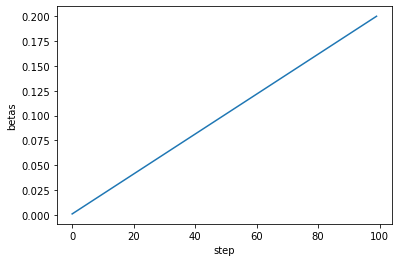

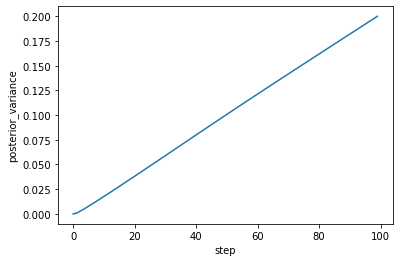

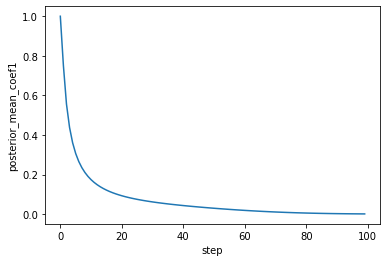

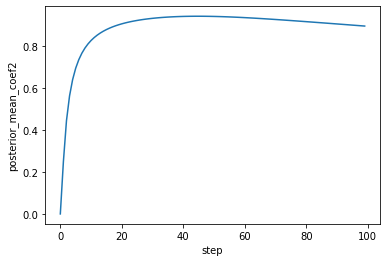

In [6]:
draw_param(n_steps,betas,name='betas')
draw_param(n_steps,posterior_variance,name='posterior_variance')
draw_param(n_steps,posterior_mean_coef1,name='posterior_mean_coef1')
draw_param(n_steps,posterior_mean_coef2,name='posterior_mean_coef2')

In [7]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [8]:
arr=np.array([1.00250941,1.57537666,6.38749852, 56.82470788,2.5753766])
broadcast_shape=[2, 3, 128, 128]
timesteps=th.tensor([3, 3])
res=_extract_into_tensor(arr, timesteps, broadcast_shape)

print(res.shape)
print(th.unique(res))

torch.Size([2, 3, 128, 128])
tensor([56.8247])


使用 DDIM 采样，为了加快生成样本的速度，可以减小时间步。具体来说，比如的时间步设置为20，在生成样本时，可以让时间步设置成5，即跨过一些时间步。

在20个时间步中怎样取出这5个时间步呢？有2种做法：

(1) 均匀采样：将20个时间步分成5等份，则得到 (0, 5, 10, 14, 19);

(2) 自定义采样：比如下面的函数中设置 section_counts= （2,2,1），表示将20个时间步先分成3等份，然后在第一份中取2个，第二份中取2个，第三份中取1个，取出的5份为：(0, 6, 7, 13, 14)

In [6]:
def space_timesteps(num_timesteps, section_counts):
    """
    Create a list of timesteps to use from an original diffusion process,
    given the number of timesteps we want to take from equally-sized portions
    of the original process.

    For example, if there's 300 timesteps and the section counts are [10,15,20]
    then the first 100 timesteps are strided to be 10 timesteps, the second 100
    are strided to be 15 timesteps, and the final 100 are strided to be 20.

    If the stride is a string starting with "ddim", then the fixed striding
    from the DDIM paper is used, and only one section is allowed.

    :param num_timesteps: the number of diffusion steps in the original
                          process to divide up.
    :param section_counts: either a list of numbers, or a string containing
                           comma-separated numbers, indicating the step count
                           per section. As a special case, use "ddimN" where N
                           is a number of steps to use the striding from the
                           DDIM paper.
    :return: a set of diffusion steps from the original process to use.
    """
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim") :])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(
                f"cannot create exactly {num_timesteps} steps with an integer stride"
            )
        section_counts = [int(x) for x in section_counts.split(",")]
    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx = 0
    all_steps = []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        if size < section_count:
            raise ValueError(
                f"cannot divide section of {size} steps into {section_count}"
            )
        if section_count <= 1:
            frac_stride = 1
        else:
            frac_stride = (size - 1) / (section_count - 1)
        cur_idx = 0.0
        taken_steps = []
        for _ in range(section_count):
            taken_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        all_steps += taken_steps
        start_idx += size
    return set(all_steps)

In [8]:
space_timesteps(num_timesteps=20, section_counts='5')

{0, 5, 10, 14, 19}

In [11]:
space_timesteps(num_timesteps=20, section_counts=[2,2,1])

{0, 6, 7, 13, 14}

In [ ]:
betas=np.array([0.005,0.59504375,0.93917149,0.98736465,0.99])

alphas = 1.0 - betas
print('alphas:',alphas,'\n')

alphas_cumprod = np.cumprod(alphas, axis=0)
print('alphas_cumprod:',alphas_cumprod,'\n')

alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
print('alphas_cumprod_prev:',alphas_cumprod_prev,'\n')

alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)
print('alphas_cumprod_next:',alphas_cumprod_next,'\n')

sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
print('sqrt_alphas_cumprod:',sqrt_alphas_cumprod,'\n')

sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
print('sqrt_one_minus_alphas_cumprod:',sqrt_one_minus_alphas_cumprod,'\n')

log_one_minus_alphas_cumprod = np.log(1.0 - alphas_cumprod)
print('log_one_minus_alphas_cumprod:',log_one_minus_alphas_cumprod,'\n')

sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
print('sqrt_recip_alphas_cumprod:',sqrt_recip_alphas_cumprod,'\n')

sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)
print('sqrt_recipm1_alphas_cumpro:',sqrt_recipm1_alphas_cumprod,'\n')

In [8]:
# 工具
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

arr=np.array([1.00250941,1.57537666,6.38749852, 56.82470788,2.5753766])
broadcast_shape=[2, 3, 128, 128]
timesteps=th.tensor([3, 3])
res=_extract_into_tensor(arr, timesteps, broadcast_shape)

print(res.shape)
print(th.unique(res))

torch.Size([2, 3, 128, 128])
tensor([56.8247])


计算

$$
q_\sigma(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})\\
$$

均值和方差为：$\mu=\sqrt{\bar{\alpha}_t} \mathbf{x}_0$,$\sum=(1 - \bar{\alpha}_t)$

In [ ]:
def q_mean_variance(self, x_start, t):
    """
    Get the distribution q(x_t | x_0).

    :param x_start: the [N x C x ...] tensor of noiseless inputs.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :return: A tuple (mean, variance, log_variance), all of x_start's shape.
    """
    mean = (
        _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
    )
    
    variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
    
    log_variance = _extract_into_tensor(
        self.log_one_minus_alphas_cumprod, t, x_start.shape
    )
    return mean, variance, log_variance

根据 $q_\sigma(\mathbf{x}_t \vert \mathbf{x}_0)$：
$$
\mathbf{x}_{t-1}=\sqrt{\bar{\alpha}_t} \mathbf{x}_0+ \sqrt{1 - \bar{\alpha}_t}\cdot \mathbf{\epsilon}；\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}; \mathbf{I})
$$

In [ ]:
def q_sample(self, x_start, t, noise=None):
    """
    Diffuse the data for a given number of diffusion steps.

    In other words, sample from q(x_t | x_0).

    :param x_start: the initial data batch.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :param noise: if specified, the split-out normal noise.
    :return: A noisy version of x_start.
    """
    if noise is None:
        noise = th.randn_like(x_start)
    assert noise.shape == x_start.shape
    return (
        _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        * noise
    )

## 2 反向过程

$$
q_\sigma(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0)
= \mathcal{N}(\mathbf{x}_{t-1}; \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot\frac{\mathbf{x}_t - \sqrt{\bar{\alpha}_t}\mathbf{x}_0}{\sqrt{1 - \bar{\alpha}_t}}, \sigma_t^2 \mathbf{I})
$$


$$
\frac{\beta_t \cdot \sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_t}\\
\frac{(1-\bar{\alpha}_{t-1})\cdot \sqrt{\alpha}_t}{1 - \bar{\alpha}_t}\\
$$

In [ ]:
self.posterior_mean_coef1 = (
        betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
)

self.posterior_mean_coef2 = (
    (1.0 - self.alphas_cumprod_prev)* np.sqrt(alphas)/ (1.0 - self.alphas_cumprod)
)

# calculations for posterior q(x_{t-1} | x_t, x_0)
self.posterior_variance = (
    betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
)

# log calculation clipped because the posterior variance is 0 at the
# beginning of the diffusion chain.
self.posterior_log_variance_clipped = np.log(
    np.append(self.posterior_variance[1], self.posterior_variance[1:])
)
        
def q_posterior_mean_variance(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior:

        q(x_{t-1} | x_t, x_0)

    """
    assert x_start.shape == x_t.shape
    posterior_mean = (
        _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
        + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
    )
    posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
    posterior_log_variance_clipped = _extract_into_tensor(
        self.posterior_log_variance_clipped, t, x_t.shape
    )
    assert (
        posterior_mean.shape[0]
        == posterior_variance.shape[0]
        == posterior_log_variance_clipped.shape[0]
        == x_start.shape[0]
    )
    return posterior_mean, posterior_variance, posterior_log_variance_clipped


In [ ]:
def p_mean_variance(
    self, model, x, t, clip_denoised=True, denoised_fn=None, model_kwargs=None
):
    """
    Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
    the initial x, x_0.

    :param model: the model, which takes a signal and a batch of timesteps
                  as input.
    :param x: the [N x C x ...] tensor at time t.
    :param t: a 1-D Tensor of timesteps.
    :param clip_denoised: if True, clip the denoised signal into [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample. Applies before
        clip_denoised.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict with the following keys:
             - 'mean': the model mean output.
             - 'variance': the model variance output.
             - 'log_variance': the log of 'variance'.
             - 'pred_xstart': the prediction for x_0.
    """
    if model_kwargs is None:
        model_kwargs = {}

    B, C = x.shape[:2]
    assert t.shape == (B,)
    model_output = model(x, self._scale_timesteps(t), **model_kwargs)

    if self.model_var_type in [ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE]:
        assert model_output.shape == (B, C * 2, *x.shape[2:])
        model_output, model_var_values = th.split(model_output, C, dim=1)
        if self.model_var_type == ModelVarType.LEARNED:
            model_log_variance = model_var_values
            model_variance = th.exp(model_log_variance)
        else:
            min_log = _extract_into_tensor(
                self.posterior_log_variance_clipped, t, x.shape
            )
            max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
            # The model_var_values is [-1, 1] for [min_var, max_var].
            frac = (model_var_values + 1) / 2
            model_log_variance = frac * max_log + (1 - frac) * min_log
            model_variance = th.exp(model_log_variance)
    else:
        model_variance, model_log_variance = {
            # for fixedlarge, we set the initial (log-)variance like so
            # to get a better decoder log likelihood.
            ModelVarType.FIXED_LARGE: (
                np.append(self.posterior_variance[1], self.betas[1:]),
                np.log(np.append(self.posterior_variance[1], self.betas[1:])),
            ),
            ModelVarType.FIXED_SMALL: (
                self.posterior_variance,
                self.posterior_log_variance_clipped,
            ),
        }[self.model_var_type]
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

    def process_xstart(x):
        if denoised_fn is not None:
            x = denoised_fn(x)
        if clip_denoised:
            return x.clamp(-1, 1)
        return x

    if self.model_mean_type == ModelMeanType.PREVIOUS_X:
        pred_xstart = process_xstart(self._predict_xstart_from_xprev(x_t=x, t=t, xprev=model_output))
        model_mean = model_output
    elif self.model_mean_type in [ModelMeanType.START_X, ModelMeanType.EPSILON]:
        if self.model_mean_type == ModelMeanType.START_X:
            pred_xstart = process_xstart(model_output)
        else:
            pred_xstart = process_xstart(self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output))
        model_mean, _, _ = self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)
    else:
        raise NotImplementedError(self.model_mean_type)

    assert (
        model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
    )
    return {
        "mean": model_mean,
        "variance": model_variance,
        "log_variance": model_log_variance,
        "pred_xstart": pred_xstart,
    }

def _predict_xstart_from_eps(self, x_t, t, eps):
    assert x_t.shape == eps.shape
    return (
        _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
        - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
    )

def _predict_xstart_from_xprev(self, x_t, t, xprev):
    assert x_t.shape == xprev.shape
    return (  # (xprev - coef2*x_t) / coef1
        _extract_into_tensor(1.0 / self.posterior_mean_coef1, t, x_t.shape) * xprev
        - _extract_into_tensor(self.posterior_mean_coef2 / self.posterior_mean_coef1, t, x_t.shape)* x_t
    )

def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
    return (
        _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
        - pred_xstart) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

def _scale_timesteps(self, t):
    if self.rescale_timesteps:
        return t.float() * (1000.0 / self.num_timesteps)
    return t

$\alpha=1-\beta$

$\bar \alpha=$


(9.95000000e-01 9.37918421e-01 8.34994215e-01 6.99637258e-01, 5.49583478e-01 4.02931466e-01 2.74311500e-01 1.72383122e-01, 9.93017510e-02 5.20027591e-02 2.45097214e-02 1.02682833e-02, 3.76413648e-03 1.18273131e-03 3.09688855e-04 6.48716654e-05, 1.01916801e)

(1.00000000e+00 9.95000000e-01 9.37918421e-01 8.34994215e-01, 6.99637258e-01 5.49583478e-01 4.02931466e-01 2.74311500e-01, 1.72383122e-01 9.93017510e-02 5.20027591e-02 2.45097214e-02, 1.02682833e-02 3.76413648e-03 1.18273131e-03 3.09688855e-04, 6.48716654e)

(9.37918421e-01 8.34994215e-01 6.99637258e-01 5.49583478e-01, 4.02931466e-01 2.74311500e-01 1.72383122e-01 9.93017510e-02, 5.20027591e-02 2.45097214e-02 1.02682833e-02 3.76413648e-03, 1.18273131e-03 3.09688855e-04 6.48716654e-05 1.01916801e-05, 1.06744439e)

torch.Size([2, 3, 128, 128])
tensor([56.8247])


sqrt_recip_alphas_cumprod
sqrt_recipm1_alphas_cumprod

In [4]:
betas=np.array([0.005,0.59504375,0.93917149,0.98736465,0.99])

alphas = 1.0 - betas
print('alphas:',alphas,'\n')

alphas_cumprod = np.cumprod(alphas, axis=0)
print('alphas_cumprod:',alphas_cumprod,'\n')

alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
print('alphas_cumprod_prev:',alphas_cumprod_prev,'\n')

alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)
print('alphas_cumprod_next:',alphas_cumprod_next,'\n')

sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
print('sqrt_alphas_cumprod:',sqrt_alphas_cumprod,'\n')

sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
print('sqrt_one_minus_alphas_cumprod:',sqrt_one_minus_alphas_cumprod,'\n')

log_one_minus_alphas_cumprod = np.log(1.0 - alphas_cumprod)
print('log_one_minus_alphas_cumprod:',log_one_minus_alphas_cumprod,'\n')

sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
print('sqrt_recip_alphas_cumprod:',sqrt_recip_alphas_cumprod,'\n')

sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)
print('sqrt_recipm1_alphas_cumpro:',sqrt_recipm1_alphas_cumprod,'\n')

alphas: [0.995      0.40495625 0.06082851 0.01263535 0.01      ] 

alphas_cumprod: [9.95000000e-01 4.02931469e-01 2.45097209e-02 3.09688902e-04
 3.09688902e-06] 

alphas_cumprod_prev: [1.00000000e+00 9.95000000e-01 4.02931469e-01 2.45097209e-02
 3.09688902e-04] 

alphas_cumprod_next: [4.02931469e-01 2.45097209e-02 3.09688902e-04 3.09688902e-06
 0.00000000e+00] 

sqrt_alphas_cumprod: [0.99749687 0.63476883 0.15655581 0.01759798 0.0017598 ] 

sqrt_one_minus_alphas_cumprod: [0.07071068 0.7727021  0.98766911 0.99984514 0.99999845] 

log_one_minus_alphas_cumprod: [-5.29831737e+00 -5.15723379e-01 -2.48150840e-02 -3.09736865e-04
 -3.09689381e-06] 

sqrt_recip_alphas_cumprod: [  1.00250941   1.57537666   6.38749859  56.8247036  568.24703598] 

sqrt_recipm1_alphas_cumpro: [7.08881205e-02 1.21729685e+00 6.30873507e+00 5.68159039e+01
 5.68246156e+02] 



In [7]:
last_alpha_cumprod = 1.0
new_betas = []
timestep_map = []
use_timesteps=[0, 1, 3,4]

for i, alpha_cumprod in enumerate(alphas_cumprod):
    if i in use_timesteps:
        new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
        last_alpha_cumprod = alpha_cumprod
        timestep_map.append(i)
    
print(new_betas)

print(timestep_map)

# betas=np.array([0.005,0.59504375,0.93917149,0.98736465,0.99])

[0.0050000000000000044, 0.59504375, 0.9992314104861715, 0.99]
[0, 1, 3, 4]


根据 $\mathbf{x}_t$，$\epsilon$，可以计算出 $\mathbf{x}_0$
$$
\begin{aligned}
\mathbf{x}_0=f^{(t)}_\theta(\mathbf{x}_t)= 
(\mathbf{x}_t- \sqrt{1 - \bar{\alpha}_t}\cdot\epsilon_{\theta}^{(t)}(\mathbf{x}_t))/\sqrt{\bar{\alpha}_t} 
\end{aligned}
$$

计算如下：

In [ ]:
def _predict_xstart_from_eps(self, x_t, t, eps):
    assert x_t.shape == eps.shape
    return (
        _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
        - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
    )

得到 $\mathbf{x}_0$ 之后，根据下式可计算出：


$$
q_\sigma(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0)
= \mathcal{N}(\mathbf{x}_{t-1}; \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot\frac{\mathbf{x}_t - \sqrt{\bar{\alpha}_t}\mathbf{x}_0}{\sqrt{1 - \bar{\alpha}_t}}, \sigma_t^2 \mathbf{I})
$$

In [ ]:
posterior_mean_coef1 = (betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod))
posterior_mean_coef2 = ((1.0 - alphas_cumprod_prev)* np.sqrt(alphas)/ (1.0 - alphas_cumprod))

def q_posterior_mean_variance(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior:

        q(x_{t-1} | x_t, x_0)

    """
    posterior_mean = (
        _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
        + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
    )
    
    posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
    
    posterior_log_variance_clipped = _extract_into_tensor(
        self.posterior_log_variance_clipped, t, x_t.shape
    )
    return posterior_mean, posterior_variance, posterior_log_variance_clipped

In [ ]:
def cond_fn(x, t, y=None):
    with torch.enable_grad():
        x_in = x.detach().requires_grad_()
        sigma = min(24, diffusion.sqrt_recipm1_alphas_cumprod[cur_t] / 4)
        kernel_size = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        x_blur = filters.gaussian_blur2d(x_in, (kernel_size, kernel_size), (sigma, sigma))
        clip_in = F.interpolate(aug(x_blur.add(1).div(2)), (clip_size, clip_size),
                                mode='bilinear', align_corners=False)
        image_embed = clip_model.encode_image(normalize(clip_in)).float()
        losses = spherical_dist_loss(image_embed, text_embed)
        grad = -torch.autograd.grad(losses.sum(), x_in)[0]
        return grad * clip_guidance_scale


def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
    """
    Compute the mean for the previous step, given a function cond_fn that
    computes the gradient of a conditional log probability with respect to
    x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
    condition on y.

    This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
    """
    gradient = cond_fn(x, self._scale_timesteps(t), **model_kwargs)
    new_mean = (
        p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
    )
    return new_mean




In [ ]:
class _WrappedModel:
    def __init__(self, model, timestep_map, rescale_timesteps, original_num_steps):
        self.model = model
        self.timestep_map = timestep_map
        self.rescale_timesteps = rescale_timesteps
        self.original_num_steps = original_num_steps

    def __call__(self, x, ts, **kwargs):
        map_tensor = th.tensor(self.timestep_map, device=ts.device, dtype=ts.dtype)
        new_ts = map_tensor[ts]
        if self.rescale_timesteps:
            new_ts = new_ts.float() * (1000.0 / self.original_num_steps)
        return self.model(x, new_ts, **kwargs)

In [ ]:
class SpacedDiffusion(GaussianDiffusion):
    """
    A diffusion process which can skip steps in a base diffusion process.

    :param use_timesteps: a collection (sequence or set) of timesteps from the
                          original diffusion process to retain.
    :param kwargs: the kwargs to create the base diffusion process.
    """

    def __init__(self, use_timesteps, **kwargs):
        self.use_timesteps = set(use_timesteps)
        self.timestep_map = []
        self.original_num_steps = len(kwargs["betas"])

        base_diffusion = GaussianDiffusion(**kwargs)  # pylint: disable=missing-kwoa
        last_alpha_cumprod = 1.0
        new_betas = []
        for i, alpha_cumprod in enumerate(base_diffusion.alphas_cumprod):
            if i in self.use_timesteps:
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                self.timestep_map.append(i)
        kwargs["betas"] = np.array(new_betas)
        super().__init__(**kwargs)

    def p_mean_variance(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().p_mean_variance(self._wrap_model(model), *args, **kwargs)

    def training_losses(
        self, model, *args, **kwargs
    ):  # pylint: disable=signature-differs
        return super().training_losses(self._wrap_model(model), *args, **kwargs)

    def condition_mean(self, cond_fn, *args, **kwargs):
        return super().condition_mean(self._wrap_model(cond_fn), *args, **kwargs)

    def condition_score(self, cond_fn, *args, **kwargs):
        return super().condition_score(self._wrap_model(cond_fn), *args, **kwargs)

    def _wrap_model(self, model):
        if isinstance(model, _WrappedModel):
            return model
        return _WrappedModel(
            model, self.timestep_map, self.rescale_timesteps, self.original_num_steps
        )

    def _scale_timesteps(self, t):
        # Scaling is done by the wrapped model.
        return t